In [ ]:
#!python --version

In [ ]:
#Nous allons installer nos librairies ici, à savoir le nlp package avec pip
!pip install nlp
#!pip install tensorflow===2.6.0 as tf 


     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 243 kB 42.1 MB/s 


In [ ]:
#pip install --upgrade tensorflow

In [ ]:
#Nous allons ensuite importer les packages nécessaires à notre analyse 
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

#Cette fonction va prendre l'objet 'history' que l'on va avoir d'après le modèle training de tensorflow,jusqu'à cette fonction.
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Ici, nous allons utiliser la confusion matrix de sklearn pour calculer nos prédictions
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import multilabel_confusion_matrix
    # from sklearn.metrics import confusion_matrix
    
    #cm = multilabel_confusion_matrix(y_true, y_pred, normalize='true')
    cm = multilabel_confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()



print('Using TensorFlow version', tf.__version__)

    



Using TensorFlow version 2.6.0


In [ ]:
# Dans cette tâche nous allons importer notre dataset
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
# Observons maintenant un peu ce dataset :
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
# Nous allons créer ces 3 objets pour séparer les 3 datasets
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
# Si nous voulons des exemples, il nous regarder les 'text' ainsi que les 'label' keys pour chacun de ces exemples 
# Nous allons créer une fonction du nom de get_tweet, celle ci va accepter un des datasets que nous avons téléchargés

# La clé text va représenter le tweet, et la clé label son label 
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


In [ ]:
# Par exemple ici on va peut prendre les tweets, ainsi que leur labels contenus dans le dataset 'train'
tweets, labels = get_tweet (train)

In [ ]:
#Ici on peut voir à partir d'un index à quoi correspond un tweet, ainsi qu'à quoi il est labellé
tweets[9], labels[9]

('i feel romantic too', 'love')

In [ ]:
# Dans tensorFlow, il ya une sorte que tokenizer que nous allons utiliser
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
# Ce système du tokenizer, nous permet de représenter chaque mot par un chiffre ou un nombre, pour que l'on puisse entrainer un modèle de machine learning
# Chacun des mots de notre dataset va donc avoir un token qui va lui être conféré, c'est ça le principe
# On peut aussi définir une limite sur le nombre qui va être utilisés régulièrement, afin que trop de tokens ne soient pas crées, ou ignorer les mots les moins utilisés

# tokenizer object using the Tokenizer class that we just imported
# Tout ce qui n'est pas dans notre most frequently used va être tokénisé comme étant du UNK 
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

#Mapping from the words to these numerics tokens
#Those are the tweets from our training set
tokenizer.fit_on_texts(tweets)


In [ ]:
# Instead of the words, here we can see a numeric values
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
#e.g - exampli gratia []
tweets[0]

'i didnt feel humiliated'

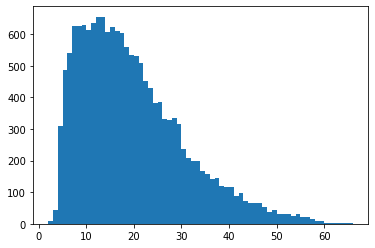

In [ ]:
# Maintenant nous allons faire un padding et un troncate des séquences générées par le Tokenizer
# Ce qui nous pousse à faire cela, c'est parce que le modèle que l'on va créer doit avoir certaines règles en matière de délimitation des mots
# Commençons par calculer ici la longueur des tweets de notre training set
# Cette histogramme nous montre clairement que la plupart de nos tweets on majoritairement entre une dizaine et une trentaine de mots
# L'on peut aussi voir que à partir de 50 ou de 60 mots, nous n'avons quasiment pas de tweets

lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
# Maintenant ce que l'on va faire ici c'est une troncation sur tous les tweets de plus de 50 mots
# Et sur les tweets de moins de 50 mots on va faire un padding dessus avec des zéros
# On va aussi importer une fonction qui va nous aider avec ce padding 

maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Avec cette fonction, on va prendre différentes séquences de notre dataset

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
tweets[0]

'i didnt feel humiliated'

In [ ]:
# Ici on peut voir qu'il a encore des valeurs, après les tokens correspondant aux mots de mon tweets
# L'on a créé un input ayant 50 valeurs, ce qui est donc un vecteur de 50 dimensions, si le tweets à trop de mots ils sera tronqué
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
# Ici nous allons maintenant préparer les labels
# L'approche ici est celle qui est souvent appliqué dans les cas de multi-classes classification 
# Et donc l'on va assigner des valeurs numériques à différentes classes
# Créeons maintenant une classe. Nous avons déja les labels de notre training set, l'on va donc créer un 'set' à partir de celles-ci
classes = set(labels)
print(classes)

{'sadness', 'love', 'joy', 'surprise', 'anger', 'fear'}


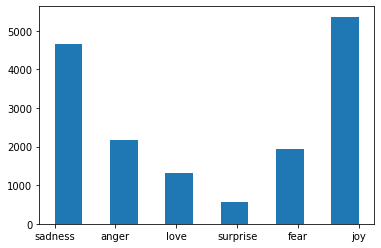

In [ ]:
# On peut voir que nous avons 6 classes, chacune d'entre elles représentant différentes émotions
# L'on peut aussi voir dans un histogramme, le nombre d'exemples que nous avons pour ces différentes classes
# On peut voir une sorte de 'class imbalance P' car nous avons beaucoup de 'tristesse' et de 'joie' mais pas assez des autres sentimens
# Ils éxiste un nombres de stratégies pour pallier à ce problème, mais nous en avons bas forcément besoin pour notre modèle
plt.hist(labels, bins=11)
plt.show()

In [ ]:
# Nous avons ensuite créer un nombre de dictionnaire pour être en mesure de convertir les noms de classes en valeurs numériques
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
# Observons class_to_index
# On peut ainsi voir que des valeurs numériques ont été assignées à des index
class_to_index

{'anger': 4, 'fear': 5, 'joy': 2, 'love': 1, 'sadness': 0, 'surprise': 3}

In [ ]:
# Et l'inverse avec les index attribués aux classes 
index_to_class 

{0: 'sadness', 1: 'love', 2: 'joy', 3: 'surprise', 4: 'anger', 5: 'fear'}

In [ ]:
# Nous allons aussi créer une fonction pour transformer les noms en ids
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [ ]:
# Nous allons ensuite créer notre modèle
# Nous allons utiliser la classe séquentiel de Keras
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                          
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
# Affichons ensuite un sommaire de notre modèl
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Donnons au validations de tweets et de labels un autre format

val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
# Car pour rappel
index_to_class 

{0: 'sadness', 1: 'love', 2: 'joy', 3: 'surprise', 4: 'anger', 5: 'fear'}

In [ ]:
# Maintenant nous allons commencer l'entrainement de notre modèle

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)


Epoch 1/20
500/500 [==============================] - 39s 58ms/step - loss: 1.3235 - accuracy: 0.4844 - val_loss: 0.8641 - val_accuracy: 0.6955
Epoch 2/20
500/500 [==============================] - 27s 55ms/step - loss: 0.6058 - accuracy: 0.7893 - val_loss: 0.5842 - val_accuracy: 0.8075
Epoch 3/20
500/500 [==============================] - 28s 55ms/step - loss: 0.3609 - accuracy: 0.8778 - val_loss: 0.4735 - val_accuracy: 0.8490
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2414 - accuracy: 0.9246 - val_loss: 0.4035 - val_accuracy: 0.8780
Epoch 5/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1674 - accuracy: 0.9479 - val_loss: 0.4284 - val_accuracy: 0.8850
Epoch 6/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1297 - accuracy: 0.9601 - val_loss: 0.4431 - val_accuracy: 0.8845
Epoch 7/20
500/500 [==============================] - 28s 55ms/step - loss: 0.0966 - accuracy: 0.9718 - val_loss: 0.4138 - val_accuracy:

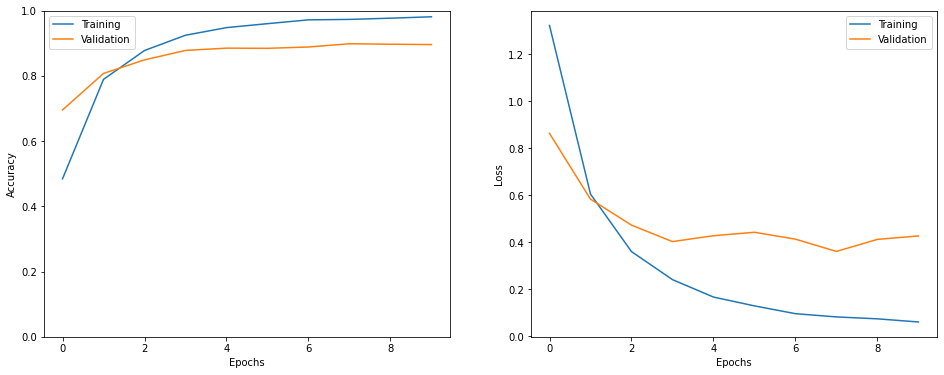

In [ ]:
# L'on peut voir au dessus, que notre modèle à fini de tourner, et nous pouvons même vérifier les accuracy et les val_loss
# Analysons maintenant l'historique de l'entrainement de notre modèle
show_history(h)

In [ ]:
# L'on peut aussi évaluer le modèle concernant la performance du 'test set'
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
# Ici l'on va refaire une évaluation 
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.4207 - accuracy: 0.8930


In [ ]:
# L'on peut aussi jeter un coup d'oeil à quelques prédictions, manuellement

i = random.randint(0, len(test_labels) -1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],  axis=0)) [0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i just went about my script of would you like mustard or sauce with that and started to feel really startled
Emotion: fear
Predicted Emotion: fear


In [ ]:
# (ORIGINAL CODE) --> preds = model.predict_classes(test_seq)
# preds = model.predict(test_seq)

#preds = model.predict_classes(test_seq)

In [ ]:
# Nous pouvons aussi faire un comparatif entre toutes les prédictions et la réalité


#np.argmax(model.predict(test_seq), axis=-1)

predictions = (model.predict(test_seq) > 0.5).astype("int32")


In [ ]:
# Ensuite nous allons observer la matrix de confusion
#show_confusion_matrix(test_labels, preds, list(classes))

#show_confusion_matrix(test_labels, predictions, list(classes))
